In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install voyager
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from voyager import Index, Space

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')

ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')

users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
print(books.shape[0])
print(ratings.shape[0])
print(users.shape[0])



/tmp/ipykernel_33/1238005996.py:20: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')


271360
1149780
278858


# Step 1 - Gather data, determine the method  of data collection and provenance of the data and Step 2 - Identify an Unsupervised Learning Problem

For this project, I wanted to experiment with building a recommender system. It is a large undertaking and requires a lot of data. I opted to attempt to build a book recommendation system, based on a Book Recommendation dataset from Kaggle.

We have studied several unsupervised learning methods in this class. To be quite honest, the lack of materials provided has been a challenge, compared to the first course on Supervised Learning. After speaking with many other students in the Slack and Discord, I did my best to dive into online resources to build this.

In this presentation, I will contrast two unsupervised learning methods (item-based filtering and SVD), and one supervised learning method (linear regression).

This data set gives us 271,360 books (ISBN# is their key), 278,858 users, and 1,149,780 ratings. Below is some information about the columns of each view of the data:

# Books

ISBN - Key identifier for the book

Book-Title

Book-Author

Year-Of-Publication

Image-URL-S

Image-URL-M

Image-URL-L


Most of these columns are fairly self-explanatory. The Image-URL-S, Image-URL-M, and Image-URL-L are the hyperlink to the book's image on Amazon. 

According to the Kaggle description, the dataset has been cleaned to only include valid ISBN's.




In [43]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# Ratings

There are three columns in the Ratings dataset.

User-ID

ISBN (the identifier for the book)

Book-Rating - an integer from 1-10, 0 a is an unrated book


In [44]:
ratings.head()
print('Total ratings = ', ratings.shape[0])
print('Total 0 ratings = ', (ratings['Book-Rating'] == 0).sum())
print('Total NA values = ', ratings['Book-Rating'].isna().sum())


Total ratings =  1149780
Total 0 ratings =  716109
Total NA values =  0


# Users

The users dataset contains the following columns:

User-ID

Location - String, with varying formats.

Age - Some NaN and extreme values (ie 140)

In [45]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# Step 3 - EDA

In a previous assignment, we focused on using our recommender system to fill in the missing ratings. In this project, I want to be able to measure the accuracy of the models, so we will be dropping the missing ratings. We want to focus on measuring the prediction error of the models we create. Let's begin by dropping all 0 ratings from the ratings data frame.

The data we are dealing with is quite scattered and sparse, particularly key features from Books (Publisher, Author) and Users (location). We'll take a look at some initial visualizations for key factors from the books data.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

publisher_counts = books['Publisher'].value_counts()
author_counts = books['Book-Author'].value_counts()
year_counts = books['Year-Of-Publication'].value_counts()

print('Number of publishers',len(publisher_counts))
print('Number of authors',len(author_counts))
print('Number of distinct years',len(year_counts))


Number of publishers 16807
Number of authors 102022
Number of distinct years 202


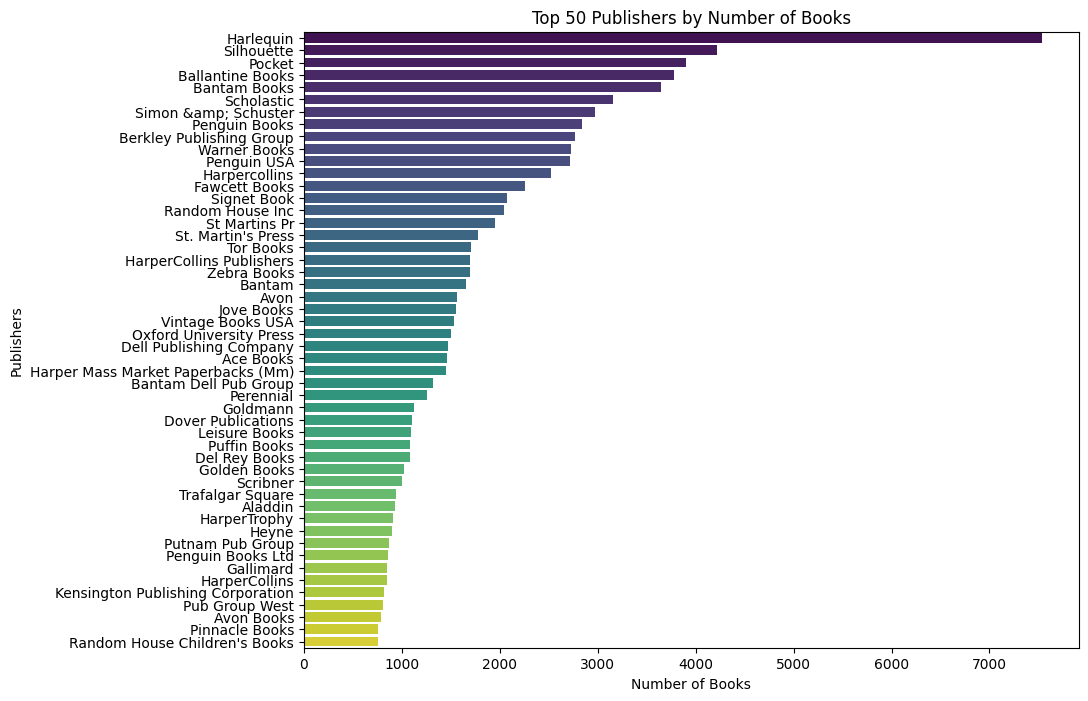

In [47]:
top_publishers = publisher_counts.head(50)
plt.figure(figsize=(10, 8))  # Set the figure size for readability
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')  # 'viridis' is just a color palette

plt.title('Top 50 Publishers by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Publishers')
plt.show()

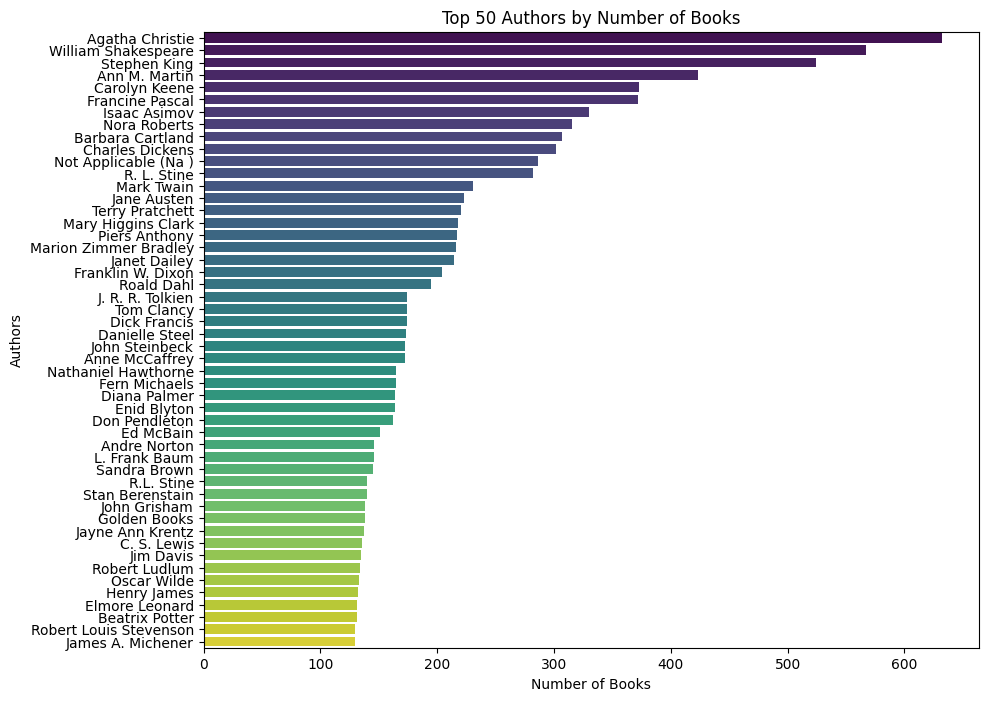

In [48]:
top_authors = author_counts.head(50)
plt.figure(figsize=(10, 8))  # Set the figure size for readability
sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')  # 'viridis' is just a color palette

plt.title('Top 50 Authors by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Authors')
plt.show()

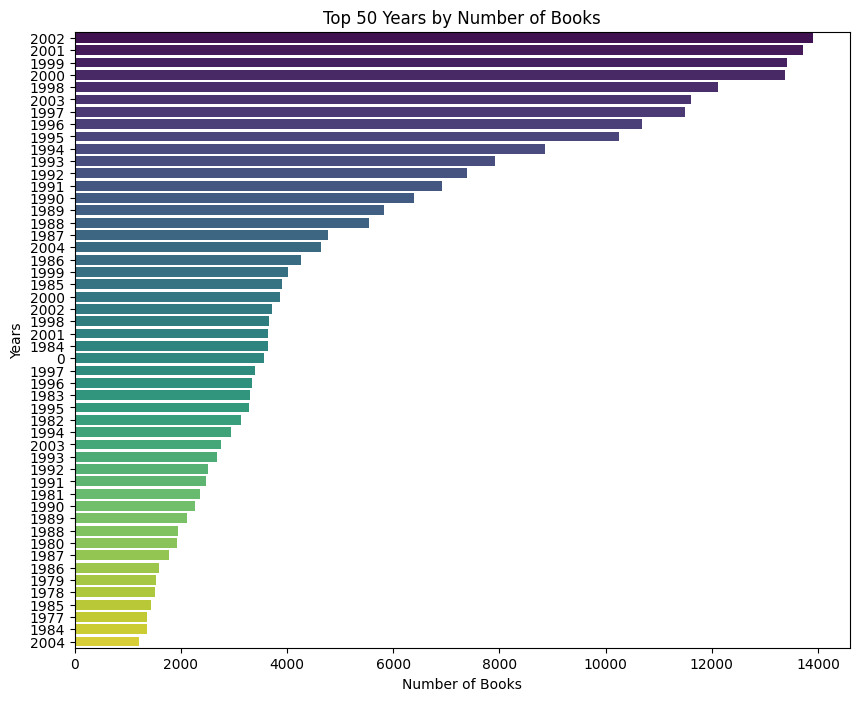

In [49]:
top_years = year_counts.head(50)
plt.figure(figsize=(10, 8))  # Set the figure size for readability
sns.barplot(x=top_years.values, y=top_years.index, palette='viridis')  # 'viridis' is just a color palette

plt.title('Top 50 Years by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Years')
plt.show()

In [50]:
#Dropping 0 ratings
ratings = ratings[ratings['Book-Rating'] != 0]
print('Total ratings =', ratings.shape[0])

Total ratings = 433671


Removing all 0's leaves us with 433,671 ratings to work with - not bad.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


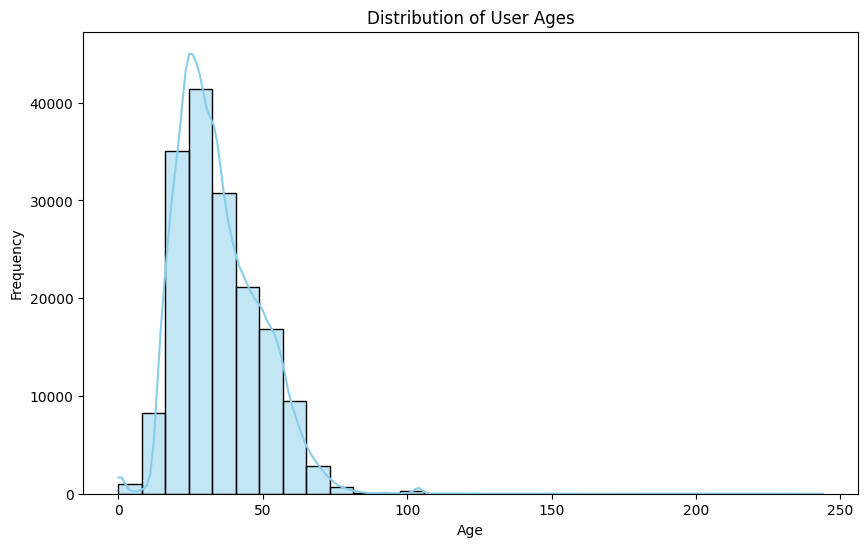

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(users['Age'], bins=30, color='skyblue', kde=True)  # kde=True adds a density curve
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Our age data does appear to be roughly normally distributed, when adjusting for the NA values.

Number of locations is  57339


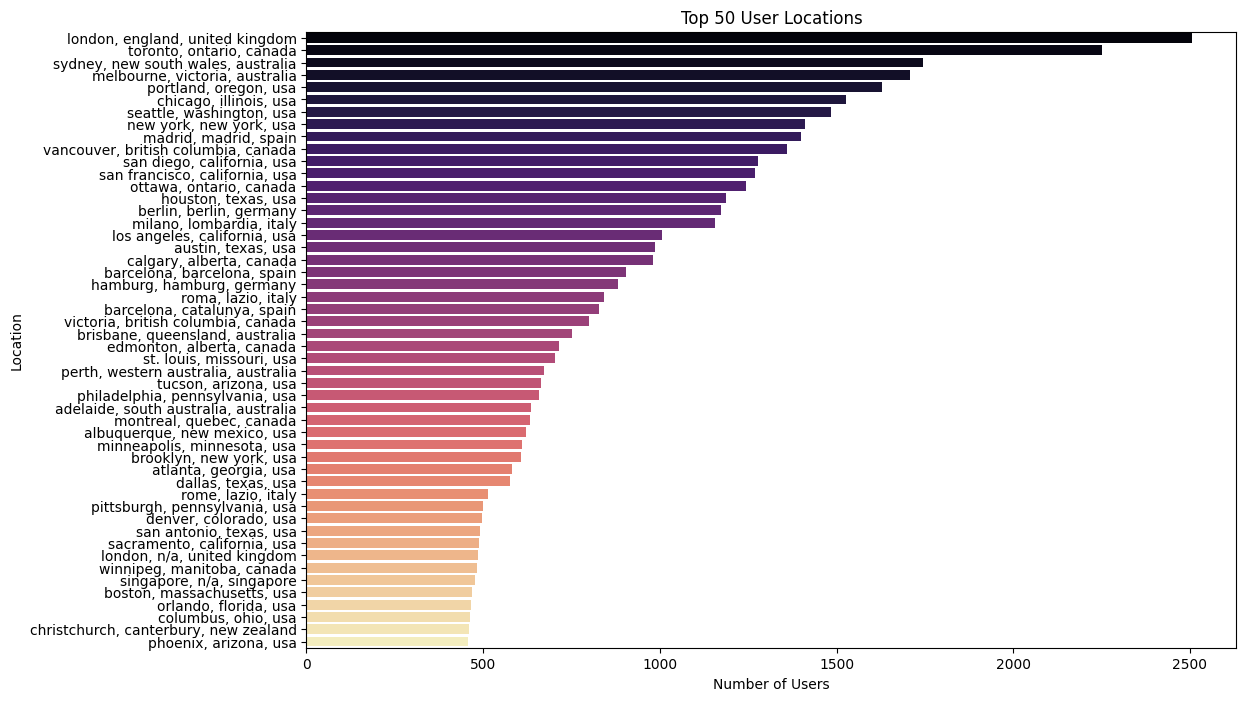

In [52]:
location_counts = users['Location'].value_counts()
top_locations = location_counts.head(50)
print('Number of locations is ',len(location_counts))
plt.figure(figsize=(12, 8))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='magma')  # 'magma' is just a color palette
plt.title('Top 50 User Locations')
plt.xlabel('Number of Users')
plt.ylabel('Location')
plt.show()


We have a massive amount of locations which reviews originate from - we will tidy this up. The above visualization is just showing us the top 50 out of 57,000!

In [53]:
users.head()
print('Total users = ', users.shape[0])
print('Total Age NA = ', np.isnan(users['Age']).sum() )
print('Total Location NA = ', users['Location'].isna().sum())
print('Total Both Age and Location NA = ', (np.isnan(users['Age']) & users['Location'].isna()).sum())

unique_location_counts = users['Location'].value_counts()
print(unique_location_counts)

age_counts = users['Age'].value_counts()
print(age_counts)



Total users =  278858
Total Age NA =  110762
Total Location NA =  0
Total Both Age and Location NA =  0
Location
london, england, united kingdom                  2506
toronto, ontario, canada                         2250
sydney, new south wales, australia               1744
melbourne, victoria, australia                   1708
portland, oregon, usa                            1629
                                                 ... 
gneisenaustr. 3, nordrhein-westfalen, germany       1
-, bayern, germany                                  1
bouchegouf, guelma, algeria                         1
indiana and philadelphia, pennsylvania, usa         1
tacoma, washington, united kingdom                  1
Name: count, Length: 57339, dtype: int64
Age
24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
168.0       1
132.0       1
159.0       1
186.0       1
127.0       1
Name: count, Length: 165, dtype: int64


Although the dataset was pre-cleaned for valid ISBN's, there are some ISBN's that have been rated that we don't have information on in our books dataset. We will remove these from our ratings.

In [54]:


isbn_not_in_books = set(ratings['ISBN']) - set(books['ISBN'])
num_isbn_not_in_books = len(isbn_not_in_books)

print(f'Number of ISBNs in ratings that are not in books: {num_isbn_not_in_books}')

#filter ratings df to only include ISBN's that are in our books df

isbn_in_books = set(books['ISBN'])

# Filter ratings to remove rows with ISBNs not in books
ratings = ratings[ratings['ISBN'].isin(isbn_in_books)]


Number of ISBNs in ratings that are not in books: 36137


It's important to note we have quite limited information available about our users - only their age and location. We have a good size of data to work with, so we'll focus on cleaning the dataset as rigorously as possible. We have some NaN values in age, as well as some very extreme age values. For now, we'll try dropping all the NaN values, as well as anyone who has entered an age less than 4 or greater than 110.

In [55]:
invalid_age_users = users[(users['Age'].isna()) | (users['Age'] < 4) | (users['Age'] > 110)]['User-ID']

users = users[~users['User-ID'].isin(invalid_age_users)]
ratings = ratings[~ratings['User-ID'].isin(invalid_age_users)]

print(ratings.shape[0])

268460


After dropping those User ID's from rating, we still have 303,802 reviews left. We'll clean the Location column next. Location is generally entered as city, region, country split by comma's. We'll take a look at the data and find a pragmatic approach to cleaning it.

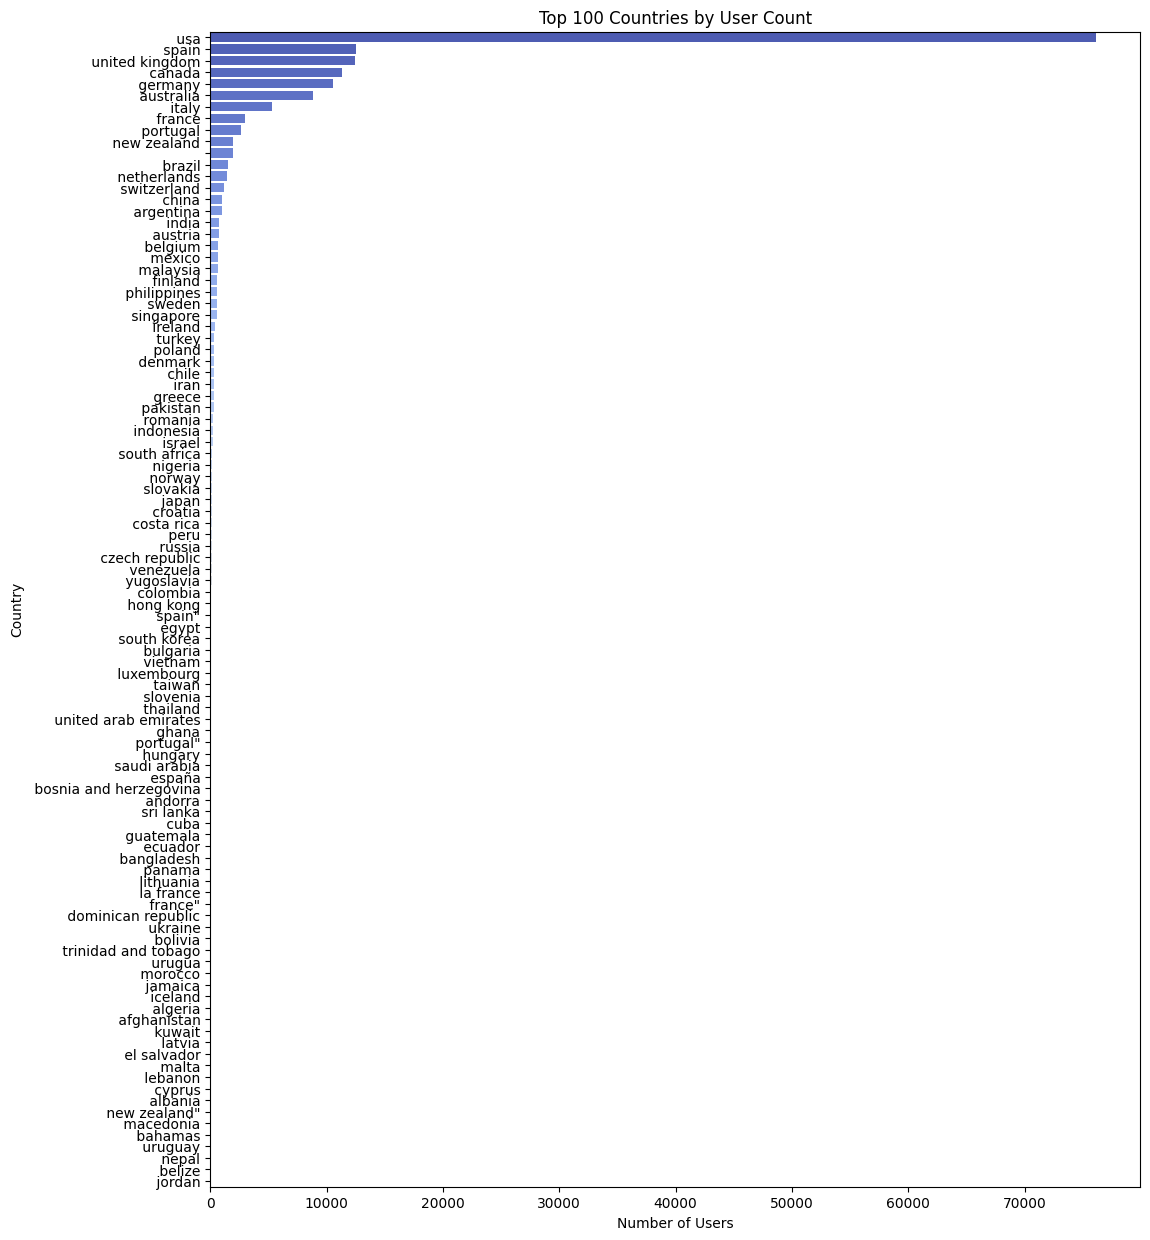

In [56]:
users['Country'] = users['Location'].str.split(',').str[-1]
unique_location_counts = users['Country'].value_counts()

top_countries = unique_location_counts.head(100)  # Adjust the number to show more or fewer countries as needed
plt.figure(figsize=(12, 15))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')  # 'coolwarm' is a visually appealing color palette
plt.title('Top 100 Countries by User Count')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()

We have a long list of countries. For effective training (especially given our limited number of user features), let's look at the distribution of our ratings, and see if we can notice any meaningful way to group geographical reasons, that will balance model practicality with geographical characteristics. We'll go through our ratings, and make a table which sums how many ratings per country we have.

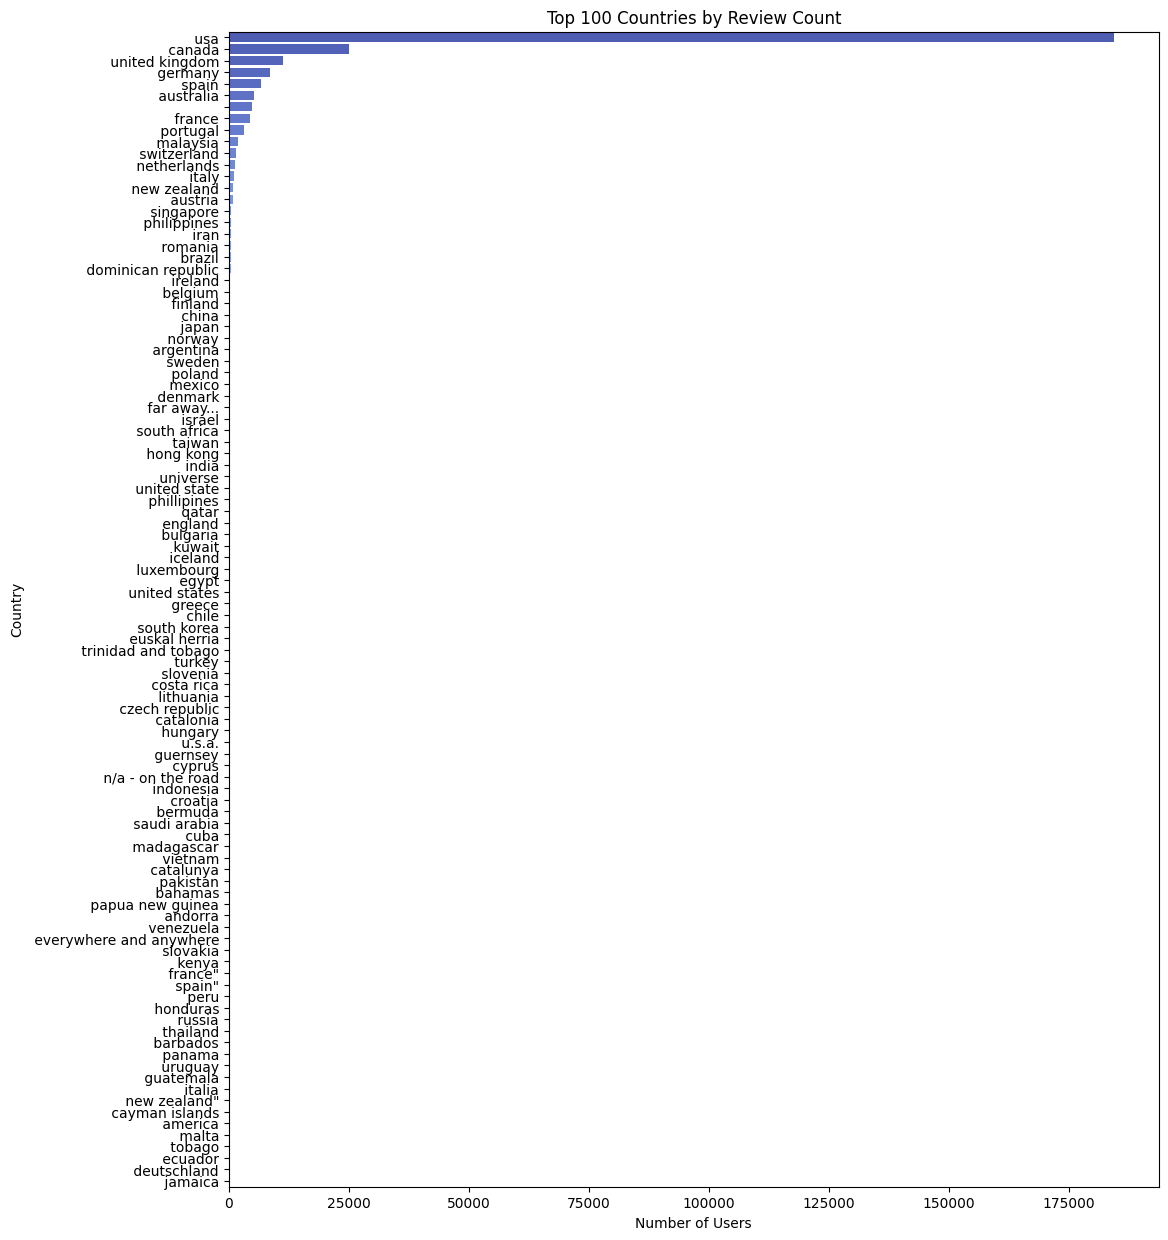

In [57]:
merged_df = pd.merge(ratings, users[['User-ID', 'Country']], on='User-ID')

country_rating_counts = merged_df.groupby('Country').size().reset_index(name='Rating Count').sort_values(by='Rating Count', ascending=False)


top_countries = country_rating_counts.head(100)  # Adjust the number to show more or fewer countries as needed
plt.figure(figsize=(12, 15))
sns.barplot(x='Rating Count', y='Country', data=top_countries ,palette='coolwarm')  # 'coolwarm' is a visually appealing color palette
plt.title('Top 100 Countries by Review Count')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()


Our review data is dominated by the USA, with significant reviews also coming from Canada, UK, EU, and Australia/NZ. To keep our training and testing efforts focused, we will categorize our reviews by those regions. We can group reviews from other areas into a category 'Other.'

We will map the Location column of the Users dataframe to USA/Canada/UK/EU/Australia-NZ/Other.



In [58]:
#Map the most commonly reported countries to their region category, and strip any leading characters.

eu_countries = [
    'germany', 'spain', 'france', 'portugal', 'italy', 
    'netherlands', 'switzerland', 'austria', 'finland', 
    'romania', 'ireland', 'belgium', 'sweden', 'norway', 
    'poland', 'denmark', 'greece', 'iceland'
]
eu_mapping = {country: 'EU' for country in eu_countries}

users['Country'] = users['Country'].replace({'new zealand':'AUS/NZ', 'australia': 'AUS/NZ'}, regex=True )
users['Country'] = users['Country'].replace(eu_mapping, regex=True)
users['Country'] = users['Country'].replace({'united state':'usa', 'united states':'usa'}, regex=True )


users['Country'] = users['Country'].str.strip()
print(users)



        User-ID                            Location   Age         Country
1             2           stockton, california, usa  18.0             usa
3             4           porto, v.n.gaia, portugal  17.0              EU
5             6       santa monica, california, usa  61.0             usa
9            10          albacete, wisconsin, spain  26.0              EU
10           11      melbourne, victoria, australia  14.0          AUS/NZ
...         ...                                 ...   ...             ...
278848   278849         georgetown, ontario, canada  23.0          canada
278850   278851                  dallas, texas, usa  33.0             usa
278851   278852     brisbane, queensland, australia  32.0          AUS/NZ
278852   278853      stranraer, n/a, united kingdom  17.0  united kingdom
278854   278855  tacoma, washington, united kingdom  50.0  united kingdom

[167146 rows x 4 columns]


In [59]:
#Map users to our primary regions, and map those outside of these regions to 'other'. Rename Country to Region

regions = ['usa','EU','canada','united kingdom','AUS/NZ']

other_user_ids = users[~users['Country'].isin(regions)]['User-ID']
users.loc[users['User-ID'].isin(other_user_ids), 'Country'] = 'other'


#temporary DF to show the distribution of regions
temp = pd.merge(ratings, users, on='User-ID')
c = temp['Country'].value_counts()

users.rename(columns ={'Country':'Region'},inplace=True)
users.drop(columns=['Location'],inplace=True)



We now have 268,460 ratings to work with, all with valid age and region info.

Our age variable has a very broad range, and we should normalize this.





In [60]:
scaler = StandardScaler()
users['Age'] = scaler.fit_transform(users[['Age']])
print(users)

        User-ID       Age          Region
1             2 -1.211904             usa
3             4 -1.283814              EU
5             6  1.880225             usa
9            10 -0.636624              EU
10           11 -1.499544          AUS/NZ
...         ...       ...             ...
278848   278849 -0.852354          canada
278850   278851 -0.133255             usa
278851   278852 -0.205165          AUS/NZ
278852   278853 -1.283814  united kingdom
278854   278855  1.089215  united kingdom

[167146 rows x 3 columns]


Next, we'll clean the data and explore feature engineering for the books data frame. Our main features are going to be the title text, publication year, author, and publisher. 

For simplicity we will standardize the year feature.

Publisher and author have very high cardinality. A couple of options to handle this would be target encoding, which is where we replace the categories with a number derived from the target - in our example, this would be the mean rating for the author, mean rating for the publisher. It helps us avoid implying a false ordinal relationship (ie if publisher A is 0 and publisher B is 1, publisher B is not greater than publisher A).

You're probably familiar with one-hot encoding, where we make 'dummy' variables for each category. This gets challenging when we have so much cardinality, but we can try top-n-one-hot encoding, where we take the top few categories, and put the rest into an 'other' category.

We'll start with target encoding to the mean publisher and author rating.

When standardizing the publication year, there are a few nonsensical values (such as year 0, or a string or Publisher name). We'll set these to the mean.

In [61]:
import re
#convert year of publication to float and standardize 
# books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'])


#function to convert the year string to a float, or return nan if not possible
def extract_number(s):
    if isinstance(s, (int, float)):
        return float(s)
    elif isinstance(s, str):
        match = re.search(r'\d+', s)
        if match:
            return float(match.group())
  
    return np.nan


books['Year'] = books['Year-Of-Publication'].apply(extract_number)


In [62]:



p = books['Year'].value_counts(dropna=False)

#calculate the mean of the appropriate years

filtered_years = books['Year'][(books['Year'] != 0) & (books['Year'] <= 2024) & books['Year'].notna()]

mean_year = filtered_years.mean()

#Set incorrect years to the mean

books['Year'] = books['Year'].apply(lambda x: mean_year if x == 0 or x > 2024 or pd.isna(x) else x)

#standardize year variable and drop old column

books['Year'] = scaler.fit_transform(books[['Year']])
books.drop(columns=['Year-Of-Publication'], inplace=True)
books.drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L'], inplace=True)

Category encoding...

In [63]:
import category_encoders as ce

#temporary DF to join books and ratings.
print(books.shape)
temp = pd.merge(ratings, books, on='ISBN')

target_book_encoder = ce.TargetEncoder(cols=['Book-Author'])
target_publisher_encoder = ce.TargetEncoder(cols=['Publisher'])


# Fit the encoder and transform the column
temp['Author_Enc'] = target_book_encoder.fit_transform(temp['Book-Author'], temp['Book-Rating'])
temp['Pub_Enc'] = target_publisher_encoder.fit_transform(temp['Publisher'], temp['Book-Rating'])

df =temp



(271360, 5)


We'll also category encode the Region feature from the users df.

In [64]:
temp = pd.merge(users,ratings,on='User-ID',how='inner')

region_mean_rating = temp.groupby('Region')['Book-Rating'].mean()

temp['Region_Encoded'] = temp['Region'].map(region_mean_rating)
users = temp[['User-ID', 'Age', 'Region_Encoded']]

users = users.drop_duplicates()


Our last bit of feature engineering will be tokenizing the titles of each of the books. We will use the tfidf vectorizer approach for this. If you are not familiar, each title will be 'tokenized' (remove stop words such as 'and','or') and converted to their base form (ie 'running'->'run'). We will set a threshold for minimum number of occurences a word must appear in the corpus, and a feature will be added to the books dataset for each word. Then, each book will have a TF-IDF score for each word in the corpus. This will transform our Book-Title feature from a sparse text feature into a number of numerical features that we can use to calculate similarity.

In [66]:

#build a tfidf matrix of word features, and affix it to our existing books dataframe.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',min_df=500)

books = df[['Book-Title','ISBN', 'Year', 'Author_Enc', 'Pub_Enc']]
df = df.drop(columns=['Book-Title','Book-Author','Publisher','Year','Author_Enc','Pub_Enc'])
books = books.drop_duplicates(subset='ISBN')


# Fit and transform the 'Title' column
tfidf_matrix = tfidf.fit_transform(books['Book-Title'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=books.index)



# Combine the TF-IDF features with the other features
books = pd.concat([books.drop(columns=['Book-Title']), tfidf_df], axis=1)


df = pd.merge(df, books, on='ISBN')

print(books)

books=books.reset_index(drop=True)

              ISBN      Year  Author_Enc   Pub_Enc  adventures  america  \
0       052165615X  0.643883    7.278074  7.842856         0.0      0.0   
1       0521795028  0.886306    7.511251  7.842856         0.0      0.0   
2       0060517794  1.128729    7.828185  7.648176         0.0      0.0   
3       0671537458  0.159036    7.482169  7.694750         0.0      0.0   
4       0679776818  0.401459    7.130010  7.762159         0.0      0.0   
...            ...       ...         ...       ...         ...      ...   
268451  014006284X -1.416715    7.513295  7.858238         0.0      0.0   
268452  0140195246  0.280248    7.529817  7.858238         0.0      0.0   
268453  0140290788  0.765094    8.020041  7.858238         0.0      0.0   
268456  0609806491  1.007518    7.641359  7.842975         0.0      0.0   
268457  1931333246  1.128729    8.031685  7.987329         0.0      0.0   

        american  amp  art  baby  ...  tales  time  true  und  vol       war  \
0            0.0  0

In [68]:
ratings_counts_per_user = ratings.groupby('User-ID')['ISBN'].count()
users_with_less_than_4_ratings = ratings_counts_per_user[ratings_counts_per_user < 4]
print(len(users_with_less_than_4_ratings))

29552


We've done a lot of work, and we've successfully converted our scattered categorical data into something numeric. 

When working with a recommender system, we want to avoid a "cold-start" problem, where we have to make a recommendation with no prior data. Based on findings from Meng, McCreadie, Macdonald and Ounis (2020) I opted for a "leave-one-last" strategy to help avoid this. Basically, we take our *interactions* (actual ratings).  For a given user, we will take one interaction for the test set, and the remainder will go to the train set. The idea is, when we make our test predictions, we will look to the train set for the items the user has reviewed, and find the most similar items, and calculate our similarity scores/predicted rating. 

For this to work, we must clean our dataset further. If a user has only one review - we will be left with no training samples for their similarity calculationn. Arguably a reviewer with only 2 or 3 reviews is not ideal either. The function below, gen_train_test, will output train and test data where each user has at least the minReviews specified in the last parameter.



In [ ]:
#function for generating train and test data, based on the minimum number of reviews specified.

def gen_train_test(ratings,books,minReviews):
    ratings_counts_per_user = ratings.groupby('User-ID')['ISBN'].count()

# Filter users with less than minRating ratings
    users_with_less_than_4_ratings = ratings_counts_per_user[ratings_counts_per_user < minReviews]

# Remove line items where 'User-ID' is in the filtered list
    ratings = ratings[~ratings['User-ID'].isin(users_with_less_than_4_ratings.index)]

    unique_user_ids = ratings['User-ID'].unique()
    unique_isbns = ratings['ISBN'].unique()

#     users = users[users['User-ID'].isin(unique_user_ids)]
#     books = books[books['ISBN'].isin(unique_isbns)]

#sort ratings, and split into train and test
    ratings = ratings.sort_values(by='User-ID')

    train_ratings = pd.DataFrame(columns=ratings.columns)
    test_ratings = pd.DataFrame(columns=ratings.columns)

    train_rows = []
    test_rows = []

# Group by 'User-ID' and process each group
    for user_id, group in ratings.groupby('User-ID'):
        # Randomly select one interaction for the test set
        test_sample = group.sample(n=1, random_state=42)
        # The rest go into the training set
        train_samples = group.drop(test_sample.index)

        # Collect the rows
        test_rows.append(test_sample)
        train_rows.append(train_samples)

    # Concatenate the lists into DataFrames
    train_ratings = pd.concat(train_rows).reset_index(drop=True)
    test_ratings = pd.concat(test_rows).reset_index(drop=True)
    
    return train_ratings, test_ratings
    
    

Another challenge arises when we attempt to use cosine similarity to find similar items. You probably had a time getting our cosine similarity function to run in Week 3 of this course. Creating an n x n similarity matrix has a massive memory and time cost. Creating a cosine similarity matrix even with this dataset was not feasible given memory constraints. I opted to use Spotify's Voyager library (a newer iteration of a library previously called Annoy). It is an approximate nearest-neighbor search algorithm, to allow one to find objects of high similarity without precomputing a similarity matrix. See my references for the link to the documentation, and I will do a high-level explanation in the demo video.

In [ ]:
#prediction function using our generated data and Spotify Voyager API
def predict_from_sim(userId,isbnPred,train_ratings,books, numNeighbors, numFeatures):
    
    d={}
    dInv={}
    books_voyager = Index(Space.Cosine,num_dimensions=numFeatures)
    items_user_has_reviewed = train_ratings[train_ratings['User-ID'] == int(userId)]
    userMean = items_user_has_reviewed['Book-Rating'].mean()
    isbn_list = items_user_has_reviewed['ISBN']
    
    books_user_has_reviewed = books[books['ISBN'].isin(isbn_list)]
    
    mat = []
    #you have the books the user reviewed, convert this into an array and use a dictionary to map array indexes to isbns.
    
    for i, (index, row) in enumerate(books_user_has_reviewed.iterrows()):
        currIsbn = row['ISBN']
        if currIsbn not in d:
            d[i] = currIsbn
            dInv[currIsbn] = i
        rowApp = row.drop('ISBN')
        mat.append(rowApp.values)
        
    matrix = np.array(mat)
    for i in range(matrix.shape[0]):
        books_voyager.add_item(matrix[i],id=i)
    
    #get the 3 most similar items
    book_row = books[books['ISBN'] == isbnPred]
    book_row = book_row.drop(columns=['ISBN'])

    book_array = book_row.values.flatten()
    
    neighbors, distances = books_voyager.query(book_array,k =numNeighbors)
    totalDist = sum(distances)
    #for each neighbor, multiply its rating by the similarity
    calc = []
    for i in range(len(neighbors)):
        neighIsbn = d[int(neighbors[i])]
        myRating = train_ratings.loc[(train_ratings['ISBN'] == neighIsbn) & (train_ratings['User-ID'] == userId), 'Book-Rating'].values[0]
        calc.append(myRating*distances[i])
    
    return sum(calc)/totalDist if totalDist > 0 else userMean
        
    

In [ ]:

# print(train_ratings.shape)
# print(test_ratings.shape)
# print(books)
# books_rev = books[['ISBN', 'Year', 'Author_Enc', 'Pub_Enc']]

We'll try an iterative approach regarding hyperparameters here. We'll try including only users that have done minimum 5, 10, or 20 reviews. Then, for Spotify Voyager, we'll try 3 nearest neighbors, 5 nearest neighbors, or 10 nearest neighbors (matched appropriately with total reviews.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

minReviews = [5,10,20]
neighborCounts = [3,5,10]

for reviewCount in minReviews:

    train_ratings, test_ratings = gen_train_test(ratings, books, reviewCount)
    
    for numNeighbors in neighborCounts:
        if numNeighbors >= reviewCount:
            break
        test_ratings['Predict'] = test_ratings.apply(lambda row: predict_from_sim(row['User-ID'], row['ISBN'], train_ratings,books, numNeighbors,88), axis=1)
        test_ratings['Predict'] = test_ratings['Predict'].round()
        test_ratings['sq-diff'] = (test_ratings['Book-Rating'] - test_ratings['Predict']) ** 2
        mse = test_ratings['sq-diff'].mean()
        rmse = np.sqrt(mse)
        print(f"***RMSE AND MAE FOR USERS WITH AT LEAST {reviewCount} REVIEWS, {numNeighbors} SIMILAR ITEMS***")
        print('RMSE = ', rmse)
        print('MAE',mean_absolute_error(test_ratings['Book-Rating'], test_ratings['Predict']))
        



# test_ratings_sample = test_ratings.sample(n=100, random_state=5)
# test_ratings_sample['Predict'] = test_ratings_sample.apply(lambda row: predict_from_sim(row['User-ID'], row['ISBN'], train_ratings,books, 5,88), axis=1)

# test_ratings_sample['Predict'] = test_ratings_sample['Predict'].round()

# test_ratings['sq-diff'] = (test_ratings['Book-Rating'] - test_ratings['Predict']) ** 2
# mspe = test_ratings['sq-diff'].mean()
# print(mspe)
# print(mean_absolute_error(test_ratings['Book-Rating'], test_ratings['Predict']))

***RMSE AND MAE FOR USERS WITH AT LEAST 5 REVIEWS, 3 SIMILAR ITEMS***
RMSE =  1.903433444096018
MAE 1.4007373477823706
***RMSE AND MAE FOR USERS WITH AT LEAST 10 REVIEWS, 3 SIMILAR ITEMS***
RMSE =  1.8226744420011496
MAE 1.3320288362512873
***RMSE AND MAE FOR USERS WITH AT LEAST 10 REVIEWS, 5 SIMILAR ITEMS***
RMSE =  1.732348078798659
MAE 1.2807415036045313
***RMSE AND MAE FOR USERS WITH AT LEAST 20 REVIEWS, 3 SIMILAR ITEMS***
RMSE =  1.831934981480777
MAE 1.3235875148162781
***RMSE AND MAE FOR USERS WITH AT LEAST 20 REVIEWS, 5 SIMILAR ITEMS***
RMSE =  1.7426257113374355
MAE 1.2666930067167128
***RMSE AND MAE FOR USERS WITH AT LEAST 20 REVIEWS, 10 SIMILAR ITEMS***
RMSE =  1.6922441434413233
MAE 1.2406163571710787


Let's compare the result with the SVD matrix factorization from Surpise. Surprise will take data with the interactions (user, item, rating), the number of latent factors to use, and generate predictions. We'll try and iterative approach with the number of latent factors for the algorithm to learn.

In [33]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate

test_ratings = test_ratings.drop(columns=['Predict','sq-diff'])

factors = [50, 100, 200]
for factor in factors:
    reader = Reader(rating_scale=(1, 10))

    # Load the data into a Surprise Dataset
    data = Dataset.load_from_df(train_ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)

    algo = SVD(n_factors = factor)

    # Perform cross-validation
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


    train_data = Dataset.load_from_df(train_ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)
    trainset = train_data.build_full_trainset()

    # Convert the test DataFrame to a list of tuples (user, item, rating)
    testset = list(test_ratings.itertuples(index=False, name=None))

    # Define the SVD algorithm
    algo = SVD()

    # Fit the algorithm on the training set
    algo.fit(trainset)

    # Make predictions on the test set
    predictions = algo.test(testset)

    # Compute and print RMSE and MAE
    print(f"Test set results with {factor} latent factors:")
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    print("RMSE = ", rmse)
    print("MAE = ", mae)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5080  1.5173  1.5105  1.5001  1.5193  1.5111  0.0069  
MAE (testset)     1.1464  1.1559  1.1515  1.1459  1.1560  1.1512  0.0044  
Fit time          2.33    2.25    2.36    2.49    2.54    2.40    0.11    
Test time         0.32    0.31    0.33    0.33    0.34    0.32    0.01    
Test set results with 50 latent factors:
RMSE: 1.5759
MAE:  1.2088
RMSE =  1.5759372879409057
MAE =  1.208767435396065
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5114  1.5039  1.5239  1.5197  1.5097  1.5137  0.0072  
MAE (testset)     1.1543  1.1476  1.1620  1.1553  1.1548  1.1548  0.0046  
Fit time          3.20    3.16    3.30    3.15    3.74    3.31    0.22    
Test time         0.33    0.31    0.31    0.32    0.37    0.33    0.02    
Test set results with 1

Lastly, we'll compare with linear regression. We'll remove our tfidf features from our books df, to avoid overfitting with too many features. We should look at the collinearity of featurers as well, given that we are taking a different approach from our similarity matrix.

In [34]:

train = pd.merge(train_ratings, books, on='ISBN',how='left')
train = pd.merge(train, users, on='User-ID',how='left')

test = pd.merge(test_ratings, books, on='ISBN',how='left')
test = pd.merge(test, users, on='User-ID',how='left')

train=train[['Book-Rating','Year','Author_Enc','Pub_Enc','Age','Region_Encoded']]
test=test[['Book-Rating','Year','Author_Enc','Pub_Enc','Age','Region_Encoded']]

train.corr()

,Book-Rating,Year,Author_Enc,Pub_Enc,Age,Region_Encoded
Book-Rating,1.000000,-0.003771,0.373437,0.208491,0.048209,0.040188
Year,-0.003771,1.000000,-0.071333,-0.042996,0.006338,0.016837
Author_Enc,0.373437,-0.071333,1.000000,0.403873,-0.048380,0.003967
Pub_Enc,0.208491,-0.042996,0.403873,1.000000,-0.025348,0.085059
Age,0.048209,0.006338,-0.048380,-0.025348,1.000000,0.119970
Region_Encoded,0.040188,0.016837,0.003967,0.085059,0.119970,1.000000


We can see collinearity between Publisher and Author target encoded features. We'll experiment with a linear regression model first, and then iteratively remove features if needed.

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import statsmodels.api as sm


y_train = train['Book-Rating']
y_test = test['Book-Rating']
X_train = train.drop(columns=['Book-Rating'])
X_test = test.drop(columns=['Book-Rating'])

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


                            OLS Regression Results                            
Dep. Variable:            Book-Rating   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5605.
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:35:55   Log-Likelihood:            -3.0542e+05
No. Observations:              159994   AIC:                         6.108e+05
Df Residuals:                  159988   BIC:                         6.109e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.4895      0.319    -35.

Our mean absolute error and rmse are a little higher than our best results from our recommendation system. We had some possible multicollinearity between Author and Region. Let's try removing Publisher and refitting the model.

In [36]:
train= train.drop(columns=['Pub_Enc'])
test= test.drop(columns=['Pub_Enc'])

train.corr()

,Book-Rating,Year,Author_Enc,Age,Region_Encoded
Book-Rating,1.000000,-0.003771,0.373437,0.048209,0.040188
Year,-0.003771,1.000000,-0.071333,0.006338,0.016837
Author_Enc,0.373437,-0.071333,1.000000,-0.048380,0.003967
Age,0.048209,0.006338,-0.048380,1.000000,0.119970
Region_Encoded,0.040188,0.016837,0.003967,0.119970,1.000000


In [37]:
y_train = train['Book-Rating']
y_test = test['Book-Rating']
X_train = train.drop(columns=['Book-Rating'])
X_test = test.drop(columns=['Book-Rating'])

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

                            OLS Regression Results                            
Dep. Variable:            Book-Rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     6800.
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:35:55   Log-Likelihood:            -3.0577e+05
No. Observations:              159994   AIC:                         6.115e+05
Df Residuals:                  159989   BIC:                         6.116e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -10.1984      0.316    -32.

Looks like our metrics stayed relatively the same, and r-squared was low. No more warning about multi-collinearity from the summary, however.

# Conclusion

This was a tough project, and was a great exercise in contrasting supervised and unsupervised learning methods. I believe that stronger model performance would have been possible had we more information about the books, and a less sparse dataset (ie, each user in the dataset has reviewed a higher volume of books). Our exploration of a linear regression model was interesting - although a low r-squared value alone can't judge the effectiveness of a model, it may be a clue that similarity measures could serve the recommendation system use case better than a linear model. 

# References

Meng, Z., McCreadie, R., Macdonald, C., & Ounis, I. (2020). Exploring data splitting strategies for the evaluation of recommendation models. In Proceedings of the 14th ACM Recommender Systems Conference (RecSys '20) (pp. [page numbers]). ACM. https://doi.org/10.1145/1122445.1122456

Holbrook, R. (2023, April 20). Target Encoding. Kaggle. https://www.kaggle.com/code/ryanholbrook/target-encoding

Kant, U. (2024, January 29). Complete Guide to Encoding Categorical Features. Kant's Chants. https://kantschants.com/complete-guide-to-encoding-categorical-features

Spotify. (n.d.). Spotify Voyager documentation. Retrieved 2024, June 15, from https://spotify.github.io/voyager/

Surprise development team. (n.d.). Matrix factorization algorithms (SVD, NMF). In Surprise documentation. Retrieved 2024,June 17, from https://surprise.readthedocs.io/en/stable/matrix_factorization.html
